In [2]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [6]:
# import dataset (comes with colab!)
data = pd.read_csv('train.csv')

# extract labels (number IDs) and remove from data
data.describe()
labels = data['label']
data   = data.drop('label',axis=1)
data.describe()
data = data.values

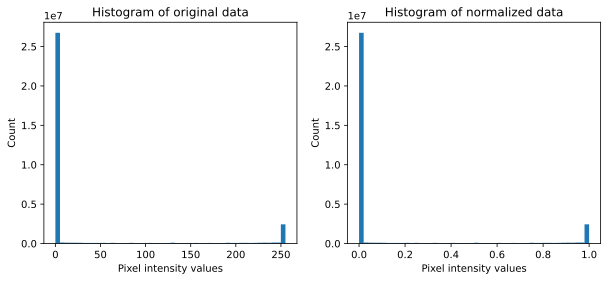

In [7]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

# Create train/test groups using DataLoader

In [8]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels.values ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [9]:
# check all variables in workspace
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
batchsize           int              32
data                ndarray          42000x784: 32928000 elems, type `int64`, 263424000 bytes (251.220703125 Mb)
dataNorm            ndarray          42000x784: 32928000 elems, type `float64`, 263424000 bytes (251.220703125 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
fig                 Figure           Figure(1000x400)
labels              Series           0        1\n1        0\n2<...>ngth: 42000, dtype: int64
labelsT             Tensor           tensor([1, 0, 1,  ..., 

# Create the DL model

In [12]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [13]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.2953, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [14]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [15]:
trainAcc,testAcc,losses,net = function2trainTheModel()


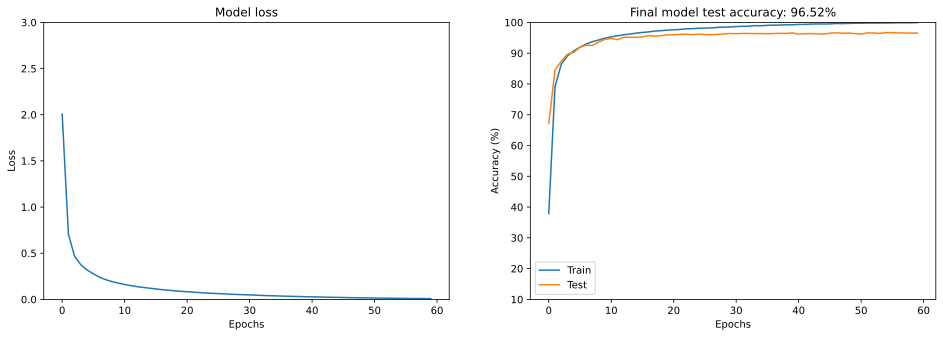

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [17]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-3.4017e+01, -2.5331e+01,  0.0000e+00,  ..., -2.6801e+01,
         -3.0695e+01, -5.5214e+01],
        [-1.8217e+01, -3.1994e+01, -2.5543e+01,  ..., -3.6985e+01,
         -8.8214e-06, -1.6511e+01],
        [-3.7997e+01, -3.9663e+01, -3.4215e+01,  ..., -4.2394e+01,
          0.0000e+00, -2.2979e+01],
        ...,
        [-1.2883e+01, -2.0020e+01, -1.0518e+01,  ..., -1.0174e+01,
         -1.8882e+01, -2.0323e+01],
        [-2.6689e+01, -1.3939e+01, -1.3556e+01,  ..., -2.4323e+01,
         -6.1989e-06, -2.0797e+01],
        [-3.2579e+01, -1.8898e+01, -2.2133e+01,  ..., -3.2917e+01,
          0.0000e+00, -1.8126e+01]])

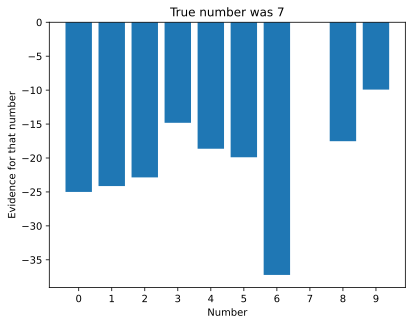

In [18]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

In [21]:
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

[  14  128  148  186  190  217  233  237  272  309  318  379  390  433
  447  459  528  530  532  563  625  684  744  765  815  819  850  866
  871  891  920  944  994 1058 1071 1129 1172 1263 1264 1288 1311 1333
 1347 1348 1377 1386 1424 1473 1589 1627 1633 1647 1662 1707 1721 1735
 1780 1801 1842 1865 1888 1969 1981 2019 2025 2051 2066 2118 2123 2164
 2201 2215 2238 2241 2293 2325 2326 2365 2378 2390 2480 2529 2564 2577
 2610 2616 2634 2664 2688 2700 2703 2731 2760 2893 2899 2904 3010 3016
 3027 3032 3041 3075 3094 3207 3254 3257 3259 3262 3268 3270 3320 3356
 3375 3385 3403 3428 3472 3508 3536 3599 3631 3644 3686 3709 3724 3780
 3817 3853 3861 3869 3899 3919 3948 3970 3971 4009 4022 4027 4073 4082
 4112 4131 4141 4170 4178 4190]


[  14  128  148  186  190  217  233  237  272  309  318  379  390  433
  447  459  528  530  532  563  625  684  744  765  815  819  850  866
  871  891  920  944  994 1058 1071 1129 1172 1263 1264 1288 1311 1333
 1347 1348 1377 1386 1424 1473 1589 1627 1633 1647 1662 1707 1721 1735
 1780 1801 1842 1865 1888 1969 1981 2019 2025 2051 2066 2118 2123 2164
 2201 2215 2238 2241 2293 2325 2326 2365 2378 2390 2480 2529 2564 2577
 2610 2616 2634 2664 2688 2700 2703 2731 2760 2893 2899 2904 3010 3016
 3027 3032 3041 3075 3094 3207 3254 3257 3259 3262 3268 3270 3320 3356
 3375 3385 3403 3428 3472 3508 3536 3599 3631 3644 3686 3709 3724 3780
 3817 3853 3861 3869 3899 3919 3948 3970 3971 4009 4022 4027 4073 4082
 4112 4131 4141 4170 4178 4190]


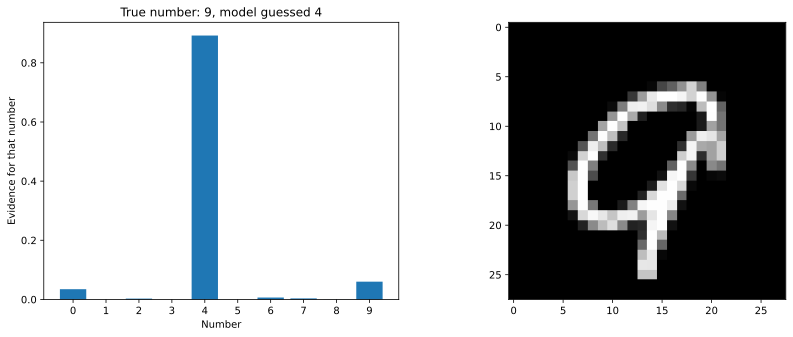

In [19]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

In [35]:
print(y)
total7 = np.where(y==7)[0]
print(total7)
error7 =np.where(y[errors] == 7)[0]
print(y[errors[error7]])
pred_error = predictions[errors[error7]]

pred7 = torch.max(pred_error, axis=1)[1]
print(pred7)

tensor([2, 8, 8,  ..., 4, 8, 8])
[   4   27   28   29   39   56   66   96  109  114  120  125  126  128
  134  135  147  149  168  187  191  195  204  213  216  220  224  246
  258  260  261  291  295  298  312  321  322  331  337  344  345  348
  350  352  359  361  376  377  398  401  413  426  428  442  447  451
  454  461  471  478  481  486  513  516  523  538  556  562  576  579
  583  588  589  606  612  617  633  637  640  651  663  675  684  699
  701  703  715  717  724  730  732  733  752  758  769  775  781  783
  785  793  801  809  812  814  820  836  845  857  858  916  931  940
  947  950  954  959  968  982  989  990  996  999 1007 1008 1010 1015
 1042 1057 1059 1069 1070 1086 1102 1106 1113 1116 1117 1119 1133 1145
 1157 1166 1168 1179 1180 1181 1183 1199 1210 1212 1215 1217 1224 1228
 1232 1256 1264 1265 1267 1269 1271 1277 1285 1300 1304 1318 1320 1326
 1340 1341 1351 1356 1359 1360 1368 1380 1382 1389 1408 1428 1443 1445
 1455 1467 1486 1491 1515 1522 1530 1548 156

# Additional explorations

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 